# EDA

In [1]:
# pip install pandas

In [2]:
# pip install pyarrow

#### IMPORT DES DONNEES

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd
data = pd.read_csv("../SBAnational.csv", low_memory=False)
data = data.drop(['ChgOffDate', 'DisbursementDate', 'DisbursementGross','BalanceGross', 'ChgOffPrinGr'], axis=1)
data.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,2.0,0,0,1,0,N,Y,P I F,"$60,000.00","$48,000.00"


In [5]:
data_secteurs = pd.read_csv("../csv_secteursactivite.csv")
data_secteurs = data_secteurs.drop("Default rate (%)", axis=1)

# Modification de certaines valeurs 
mapping = {"31–33": "31", "44–45": "44", "48–49": "48"}
data_secteurs['2 digit code'] = data_secteurs['2 digit code'].replace(mapping)

# Création et Ajout de nouvelles lignes
nouvelles_lignes = [{'2 digit code': 32, 'Description': 'Manufacturing'},
                    {'2 digit code': 33, 'Description': 'Manufacturing'},
                    {'2 digit code': 45, 'Description': 'Retail trade'},
                    {'2 digit code': 49, 'Description': 'Transportation and warehousing'}]

# data_secteurs = data_secteurs.append(nouvelles_lignes, ignore_index=True)

# Concaténation
nouvelles_lignes_df = pd.DataFrame(nouvelles_lignes)
data_secteurs = pd.concat([data_secteurs, nouvelles_lignes_df], ignore_index=True)

# Conversion de la variable en int
data_secteurs["NAICS_id"] = data_secteurs["2 digit code"].astype(int)
data_secteurs = data_secteurs.drop("2 digit code", axis=1)
data_secteurs.head(5)


,Description,NAICS_id
0,"Mining, quarrying, and oil and gas extraction",21
1,"Agriculture, forestry, fishing and hunting",11
2,Management of companies and enterprises,55
3,Health care and social assistance,62
4,Utilities,22


### NETTOYAGE & PREPARATION DES DONNEES

In [6]:
# CONVERSION DES VARIABLES GrAppv ET SBA_Appv EN FORMAT FLOAT
def amount_to_float(s: str) -> float:
    """Converts a 'string' amount in $ to its float value"""
    return float(s[1:].replace(',', ''))

data["GrAppv"] = data["GrAppv"].apply(amount_to_float)
data["SBA_Appv"] = data["SBA_Appv"].apply(amount_to_float)

In [7]:
# CONVERSION DE LA VARIABLE ApprovalFY EN FORMAT INTEGER
def str_to_int(s: str) -> int:
    """Converts a 'string' digit into an integer and deletes string characters if necessary"""
    s = ''.join(char for char in str(s) if char.isdigit())
    return int(s) if s else None

data["ApprovalFY"] = data["ApprovalFY"].apply(str_to_int)

In [8]:
# CONVERSION DE LA VARIABLE ApprovalDate EN FORMAT DATETIME
data['ApprovalDate'] = pd.to_datetime(data['ApprovalDate'], errors='coerce')
data['ApprovalYear'] = data['ApprovalDate'].dt.year
data['ApprovalMonth'] = data['ApprovalDate'].dt.month
data['ApprovalDay'] = data['ApprovalDate'].dt.day
data = data.drop("ApprovalDate", axis=1)
data.head(1)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,...,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv,ApprovalYear,ApprovalMonth,ApprovalDay
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997,84,...,1,0,N,Y,P I F,60000.0,48000.0,1997,2,28


In [9]:
from datetime import datetime

# Updated recession periods with the COVID-19 pandemic recession
recession_periods = [
    (1969, 1970),
    (1973, 1975),
    (1980, 1980),
    (1981, 1982),
    (1990, 1991),
    (2001, 2001),
    (2007, 2009),
    (2020, 2020),  # Including the COVID-19 pandemic recession
]

# Function to check if a given year (from dt.year) was in recession
def is_year_in_recession(year):
    # The year parameter is expected to be an integer
    return any(start <= year <= end for start, end in recession_periods)

# Example usage of the function with datetime objects
current_year = datetime.now().year
# print(is_year_in_recession(current_year))  # Example: Check for the current year

data["Recession"] = data["ApprovalYear"].apply(is_year_in_recession)

In [10]:
# CREATION D'UNE AUTRE COLONNE NAICS 
data['NAICS_id'] = data['NAICS'].copy()
data['NAICS_id'] = data['NAICS_id'].astype(str).str[:2]
data['NAICS_id'] = data['NAICS_id'].astype('Int64')

# MERGE AVEC LE DATASET DES SECTEURS D'ACTIVITE
dataset = pd.merge(data, data_secteurs, on='NAICS_id', how='outer')

# SUPPRESSION DE LA COLONNE
# dataset = dataset.drop('NAICS_x', axis=1)
dataset = dataset.rename(columns={"NAICS_y" : "NAICS"})
dataset.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,...,LowDoc,MIS_Status,GrAppv,SBA_Appv,ApprovalYear,ApprovalMonth,ApprovalDay,Recession,NAICS_id,Description
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997,84,...,Y,P I F,60000.0,48000.0,1997,2,28,False,45,Retail trade


In [11]:
# CREATION D'UNE COLONNE SameState POUR CAPTURER UNE RELATION ENTRE STATE DU CLIENT ET STATE DE LA BANK
dataset["SameState"] = (dataset['State'] == dataset['BankState']).astype(bool)

In [12]:
dataset = dataset.drop("LoanNr_ChkDgt", axis=1)
dataset.shape

(899164, 27)

In [13]:
# VALEURS NaN SUR TOUT LE DATASET
dataset_nan = dataset[dataset.isna().any(axis=1)]
len(dataset_nan)

209346

In [14]:
# DATASET OU LA TARGET EST REMPLIE DE NaN
MIS_nan = dataset[dataset["MIS_Status"].isna()]
len(MIS_nan)

1997

In [15]:
# CREATION D'UN DATASET SANS LES NaN DANS LA TARGET (il reste des NaN ailleurs qu'il faudra traiter)
dataframe = dataset[dataset["MIS_Status"].isna() == False]
len(dataframe)

897167

In [16]:
# TRANSFORMATION DES VALEURS NaN de NewExist EN 3 (catégorie non renseignée) ET CONVERSION DE LA VARIABLE EN INTEGER
# dataframe["NewExist"] = dataframe["NewExist"].fillna(3, axis=0).astype("Int64")
dataframe.loc[dataframe["NewExist"].isnull(), "NewExist"] = 0
dataframe["NewExist"] = dataframe["NewExist"].astype("Int64")

/tmp/ipykernel_13551/2680347995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["NewExist"] = dataframe["NewExist"].astype("Int64")


In [17]:
# import dtale
# dtale.show(data)

In [18]:
dataframe.head(3)

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,...,MIS_Status,GrAppv,SBA_Appv,ApprovalYear,ApprovalMonth,ApprovalDay,Recession,NAICS_id,Description,SameState
0,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997,84,4,...,P I F,60000.0,48000.0,1997,2,28,False,45,Retail trade,False
1,DEE'S CORNER BAIT & TACKLE,SAINT PETER,MN,56082,WELLS FARGO BANK NATL ASSOC,MN,451110,1997,60,2,...,P I F,39500.0,29625.0,1997,2,28,False,45,Retail trade,True
2,PPP COMMUNICATIONS,WASHINGTON,IA,52353,WASHINGTON STATE BANK,IA,454210,1997,84,2,...,P I F,30000.0,22500.0,1997,2,28,False,45,Retail trade,True


In [19]:
dataframe.NAICS.value_counts()

0         201667
722110     27941
722211     19435
811111     14539
621210     14034
           ...  
111130         1
112420         1
327120         1
111992         1
514190         1
Name: NAICS, Length: 1312, dtype: int64

### SWEETVIZ

In [20]:
# pip install sweetviz

In [21]:
# import sweetviz as sv
# #dataframe = dataframe.dropna()
# dataset['ApprovalFY'] = pd.to_numeric(dataset['ApprovalFY'], errors='coerce').astype('Int64')
# dataset = dataset.dropna()
# my_report = sv.analyze(data)
# my_report.show_html()

### YDATA

In [22]:
# pip install pandas-profiling

In [23]:
# pip install jupyter

In [24]:
# pip install ipywidgets

In [25]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(data, title="Profiling Report")
# profile

### EDA ANALYSE UNIVARIEE

#### NAME 

In [26]:
dataset.Name.describe()

count     899150
unique    779583
top       SUBWAY
freq        1269
Name: Name, dtype: object

In [27]:
filtre = dataset.Name.value_counts() == 1
filtre.value_counts()

True     706468
False     73115
Name: Name, dtype: int64

In [28]:
dataset.Name.isnull().sum()
# ON REMPLACE CES VALEURS OU ON LES SUPPR?

14

In [29]:
# CONCLUSION : VARIABLE A SUPPRIMER
# CREER UNE NOUVELLE VARIABLE (UN PRET OU PLUSIEURS PRETS)

#### CITY

In [30]:
dataframe.City.describe()

count          897137
unique          32566
top       LOS ANGELES
freq            11550
Name: City, dtype: object

In [31]:
dataframe.City.isnull().sum()

30

In [32]:
dataframe.City.value_counts()

LOS ANGELES    11550
HOUSTON        10229
NEW YORK        7834
CHICAGO         6009
MIAMI           5594
               ...  
Selden             1
PARSON             1
Philadephia        1
FRIECO             1
N HAMPTON          1
Name: City, Length: 32566, dtype: int64

In [33]:
# Suppression ou Remplacement des valeurs manquantes?
# A voir avec ZIP > on va sûrement garder ZIP pour le modèle et suppr cette variable City

In [34]:
# TOP 20 des Villes (Count=Nb de demandes de prêts)
dataframe.groupby("City").count().sort_values(by="Name", ascending=False).head(10)
top10_city = dataframe.groupby("City").count().sort_values(by="Name", ascending=False).reset_index()
top10_city = top10_city[["City", "Name"]]
top10_city = top10_city.rename(columns={"Name" : "Total_Loan_Applications"})
top10_city.head(20)

,City,Total_Loan_Applications
0,LOS ANGELES,11550
1,HOUSTON,10228
2,NEW YORK,7834
3,CHICAGO,6009
4,MIAMI,5594
5,SAN DIEGO,5359
6,DALLAS,5084
7,PHOENIX,4490
8,LAS VEGAS,4388
9,SPRINGFIELD,3728


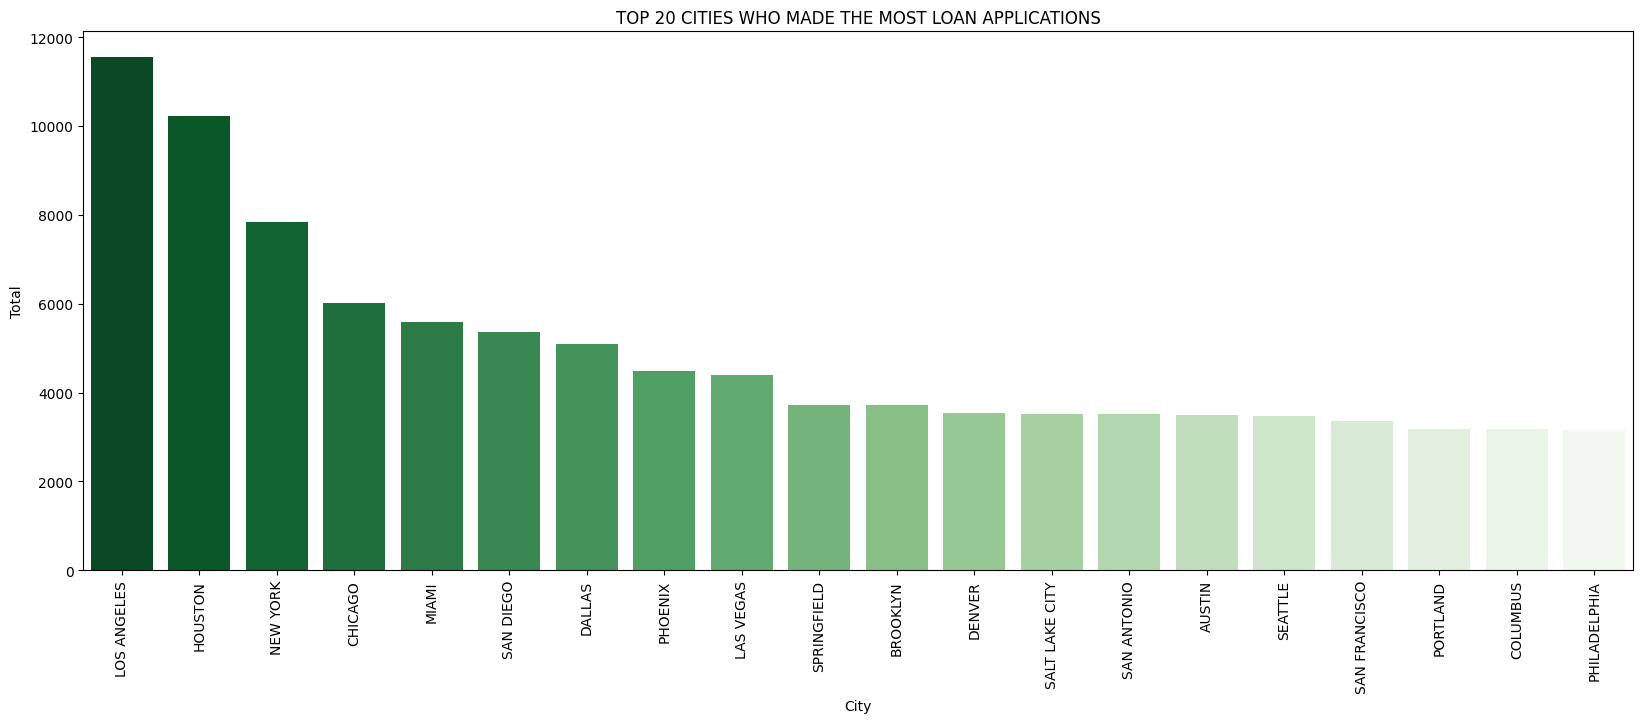

In [35]:
test = dataframe.groupby("City").count().reset_index()
test = test.rename(columns={"Name": "Total"})
test_top = test.sort_values(by="Total", ascending=False).head(20)
test_top = test_top[["City", "Total"]]
plt.figure(figsize=(20,7))
plt.title("TOP 20 CITIES WHO MADE THE MOST LOAN APPLICATIONS")
sns.barplot(test_top, x='City', y="Total", palette="Greens_r")
plt.xticks(rotation='vertical')
plt.show()

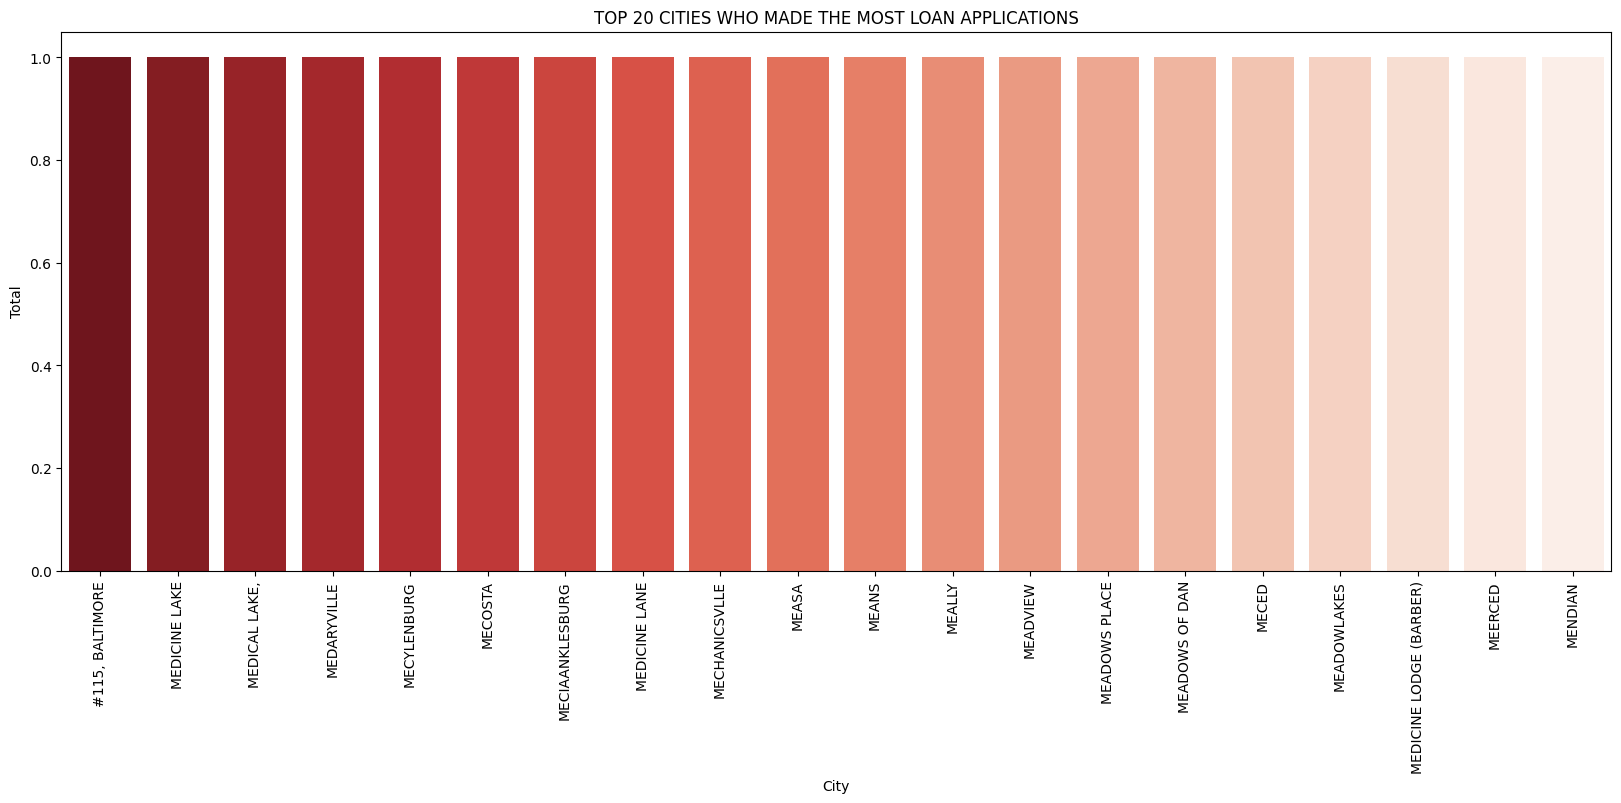

In [36]:
test_flop = test.sort_values(by="Total", ascending=True).head(20)
test_flop = test_flop[["City", "Total"]]
plt.figure(figsize=(20,7))
plt.title("TOP 20 CITIES WHO MADE THE MOST LOAN APPLICATIONS")
sns.barplot(test_flop, x='City', y="Total", palette="Reds_r")
plt.xticks(rotation='vertical')
plt.show()

In [37]:
# ON PEUT REGROUPER PAR ANNEE AUSSI

In [38]:
test2 = dataframe.groupby(["City", "ApprovalYear"]).count().reset_index()
test2 = test2.sort_values(by="Name", ascending=False)
test2.head(20)

,City,ApprovalYear,Name,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,...,LowDoc,MIS_Status,GrAppv,SBA_Appv,ApprovalMonth,ApprovalDay,Recession,NAICS_id,Description,SameState
85685,LOS ANGELES,2004,1501,1501,1501,1501,1501,1501,1501,1501,...,1501,1501,1501,1501,1501,1501,1501,1501,1501,1501
85688,LOS ANGELES,2007,1312,1312,1312,1312,1312,1312,1312,1312,...,1312,1312,1312,1312,1312,1312,1312,1312,1312,1312
85684,LOS ANGELES,2003,1236,1236,1236,1236,1236,1236,1236,1236,...,1236,1236,1236,1236,1236,1236,1236,1236,1236,1236
85687,LOS ANGELES,2006,1014,1014,1014,1014,1014,1014,1014,1014,...,1014,1014,1014,1014,1014,1014,1014,1014,1014,1014
105310,NEW YORK,2004,1007,1007,1007,1007,1007,1007,1007,1007,...,1007,1007,1007,1007,1007,1007,1007,1007,1007,1007
85686,LOS ANGELES,2005,984,984,984,984,984,984,984,984,...,984,984,984,984,984,984,984,984,984,984
105312,NEW YORK,2006,940,940,940,940,940,940,940,940,...,940,940,940,940,940,940,940,940,940,940
68631,HOUSTON,2006,916,916,916,916,916,916,916,916,...,916,916,916,916,916,916,916,916,916,916
68629,HOUSTON,2004,899,899,899,899,899,899,899,899,...,899,899,899,899,899,899,899,899,899,899
25872,CHICAGO,2006,884,884,884,884,884,884,884,884,...,884,884,884,884,884,884,884,884,884,884


In [39]:
dataframe.ApprovalYear.describe()

count    897167.000000
mean       2000.922194
std           5.957414
min        1974.000000
25%        1996.000000
50%        2002.000000
75%        2006.000000
max        2073.000000
Name: ApprovalYear, dtype: float64

In [40]:
# SUPPRESSION DE LA VARIABLE "CITY"
dataframe = dataframe.drop("City", axis=1)

#### STATE

In [41]:
dataframe.State.describe()

count     897154
unique        51
top           CA
freq      130488
Name: State, dtype: object

In [42]:
dataframe.State.isnull().sum()

13

In [43]:
# Valeurs manquantes à REMPLACER ou SUPPRIMER
dataframe.query("State.isna()")

,Name,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,...,MIS_Status,GrAppv,SBA_Appv,ApprovalYear,ApprovalMonth,ApprovalDay,Recession,NAICS_id,Description,SameState
17508,"GOLF SHOES UNLIMITED, INC.",NaN,33410,"BEAL BANK, SSB",TX,451110,1990,84,3,2,...,P I F,75000.0,67500.0,1989,10,19,False,45,Retail trade,False
173972,TRYON COATS & LEATHER,NaN,0,KEYBANK NATIONAL ASSOCIATION,NY,0,1966,282,0,0,...,CHGOFF,60000.0,54000.0,2066,5,18,False,0,NaN,False
215643,CENTURY 21 PHILLIPS REALTY,NaN,95682,SBA - EDF ENFORCEMENT ACTION,CO,0,1987,240,19,1,...,P I F,83000.0,83000.0,1987,2,12,False,0,NaN,False
239091,CASCO SERVICE,NaN,54205,UNION STATE BANK,WI,0,1990,204,8,1,...,P I F,300000.0,252600.0,1989,10,19,False,0,NaN,False
239356,P & P TOOL INC,NaN,54025,FIRST BANK OF BALDWIN,WI,0,1990,240,7,1,...,P I F,82000.0,73800.0,1989,10,26,False,0,NaN,False
360560,"VERANDA INTERIORS, INC.",NaN,76645,PROSPERITY BANK,TX,0,1997,120,3,1,...,P I F,100000.0,80000.0,1996,10,24,False,0,NaN,False
433033,KING'S TRUCK WASH,NaN,67219,SOUTH CENT. KANSAS ECONOMIC DE,KS,811192,1988,120,17,2,...,P I F,119000.0,119000.0,1988,8,5,False,81,Other services (except public administration),False
543561,"OLSON ELECTRIC SERVICE, INC.",NaN,75236,PROSPERITY BANK,TX,235310,1996,60,17,1,...,P I F,40000.0,32000.0,1996,7,9,False,23,Construction,False
543652,METRO SHEETMETAL & ERECTION,NaN,76052,PROSPERITY BANK,TX,235610,1996,84,3,1,...,P I F,80000.0,64000.0,1996,7,23,False,23,Construction,False
580392,WILLIAMS JEWELERS,NaN,84124,ZIONS FIRST NATIONAL BANK,UT,448310,1990,60,4,1,...,P I F,250000.0,212500.0,1989,12,14,False,44,Retail trade,False


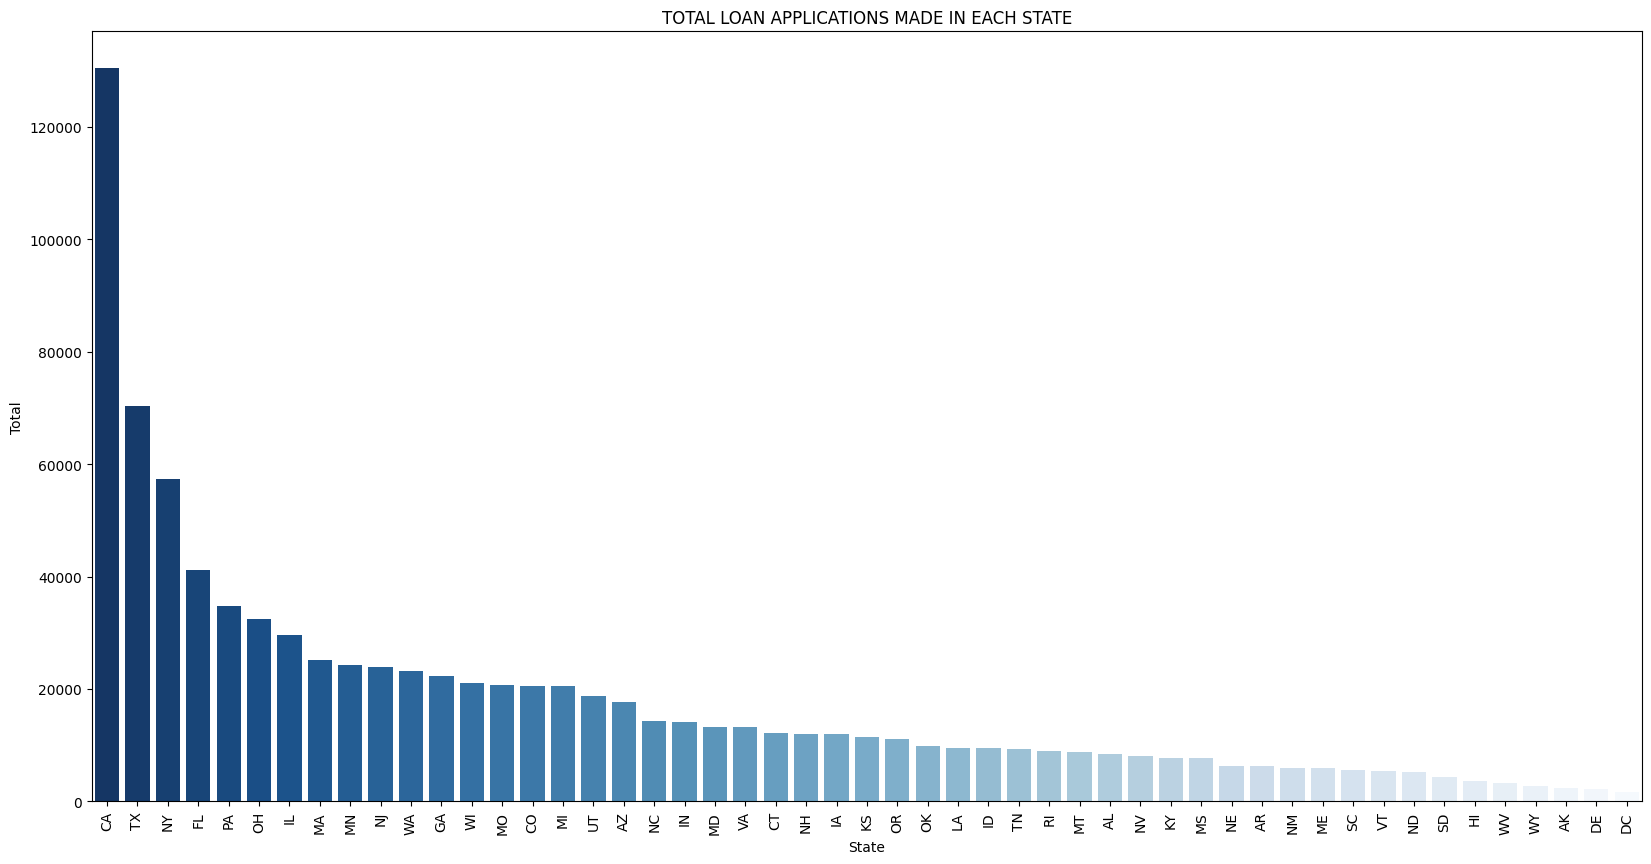

In [44]:
test = dataframe.groupby("State").count().reset_index()
test = test.rename(columns={"Name": "Total"})
test_top = test.sort_values(by="Total", ascending=False)
test_top = test_top[["State", "Total"]]
plt.figure(figsize=(20,10))
plt.title("TOTAL LOAN APPLICATIONS MADE IN EACH STATE")
sns.barplot(test_top, x='State', y="Total", palette="Blues_r")
plt.xticks(rotation='vertical')
plt.grid(False)
plt.show()

#### ZIP

In [45]:
dataframe.Zip.isnull().sum()

0

In [46]:
dataframe.Zip.describe()

count    897167.000000
mean      53856.710734
std       31170.471151
min           0.000000
25%       27612.000000
50%       55416.000000
75%       83706.000000
max       99999.000000
Name: Zip, dtype: float64

In [47]:
dataframe = dataframe.drop(columns="Zip")

#### BANK

In [48]:
dataframe.Bank.describe()

count                         895661
unique                          5801
top       BANK OF AMERICA NATL ASSOC
freq                           86773
Name: Bank, dtype: object

In [49]:
# QUE FAIRE DES NaN?
dataframe.Bank.isnull().sum()

1506

In [50]:
filtre = dataframe.Bank.value_counts() > 1
filtre.value_counts()

True     4878
False     923
Name: Bank, dtype: int64

In [51]:
dataframe.Bank = dataframe.Bank.fillna("MISSING")
dataframe.Bank.value_counts()

BANK OF AMERICA NATL ASSOC        86773
WELLS FARGO BANK NATL ASSOC       63461
JPMORGAN CHASE BANK NATL ASSOC    48131
U.S. BANK NATIONAL ASSOCIATION    35112
CITIZENS BANK NATL ASSOC          33770
                                  ...  
GOUVERNEUR S & L ASSOC                1
NEVADA BANK & TRUST COMPANY           1
1ST NATL BK OF FLETCHER               1
THE SCOTT COUNTY STATE BANK           1
FIRSTECH, INC.                        1
Name: Bank, Length: 5802, dtype: int64

#### BANKSTATE

In [52]:
dataframe.BankState.describe()

count     895654
unique        56
top           CA
freq      118034
Name: BankState, dtype: object

In [53]:
# QUE FAIRE DES NaN?
# REMPLACER LES VALEURS NAN PAR "MISSING" (BANQUES ETRANGERES)
dataframe.BankState.isnull().sum()
dataframe.BankState = dataframe.BankState.fillna("MISSING")
dataframe.BankState.value_counts()

CA         118034
NC          79455
IL          65864
OH          58430
SD          51065
TX          47761
RI          44117
NY          39546
VA          28960
DE          24524
MN          19950
UT          18994
PA          17050
WI          15404
MO          14844
MA          13845
GA          13805
FL          13803
AL          12128
OR          11373
WA          10689
CO          10580
CT           9907
IA           9860
NJ           9434
KS           8869
MT           7848
IN           7619
SC           7471
MI           7366
OK           7322
MD           6995
NH           6794
AR           6311
MS           5924
TN           5619
NE           5336
ND           5104
LA           5057
VT           4751
NM           4416
KY           4380
NV           4323
ID           4314
DC           4003
AZ           3957
ME           3689
HI           2989
WY           2167
WV           2006
MISSING      1513
AK           1439
PR            155
GU              5
EN              1
AN        

In [54]:
dataframe.query("BankState.isna()")

,Name,State,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,MIS_Status,GrAppv,SBA_Appv,ApprovalYear,ApprovalMonth,ApprovalDay,Recession,NAICS_id,Description,SameState


In [55]:
test = dataframe.query("BankState.isna()")
test.Bank.value_counts()

Series([], Name: Bank, dtype: int64)

#### NAICS (aka : Description & NAICS_id)

In [56]:
dataframe.Description.isnull().sum()

201667

In [57]:
dataframe.Description.value_counts()

Retail trade                                                     126975
Other services (except public administration)                     72395
Professional, scientific, and technical services                  67922
Manufacturing                                                     67903
Accommodation and food services                                   67511
Construction                                                      66492
Health care and social assistance                                 55264
Wholesale trade                                                   48673
Administrative/support & waste management/remediation Service     32529
Transportation and warehousing                                    22408
Arts, entertainment, and recreation                               14616
Real estate and rental and leasing                                13588
Information                                                       11362
Finance and insurance                                           

In [58]:
dataframe.Description = dataframe.Description.fillna("Unknown")

In [59]:
#dataframe.query("Description.isna()")
dataframe.Description.value_counts()

Unknown                                                          201667
Retail trade                                                     126975
Other services (except public administration)                     72395
Professional, scientific, and technical services                  67922
Manufacturing                                                     67903
Accommodation and food services                                   67511
Construction                                                      66492
Health care and social assistance                                 55264
Wholesale trade                                                   48673
Administrative/support & waste management/remediation Service     32529
Transportation and warehousing                                    22408
Arts, entertainment, and recreation                               14616
Real estate and rental and leasing                                13588
Information                                                     

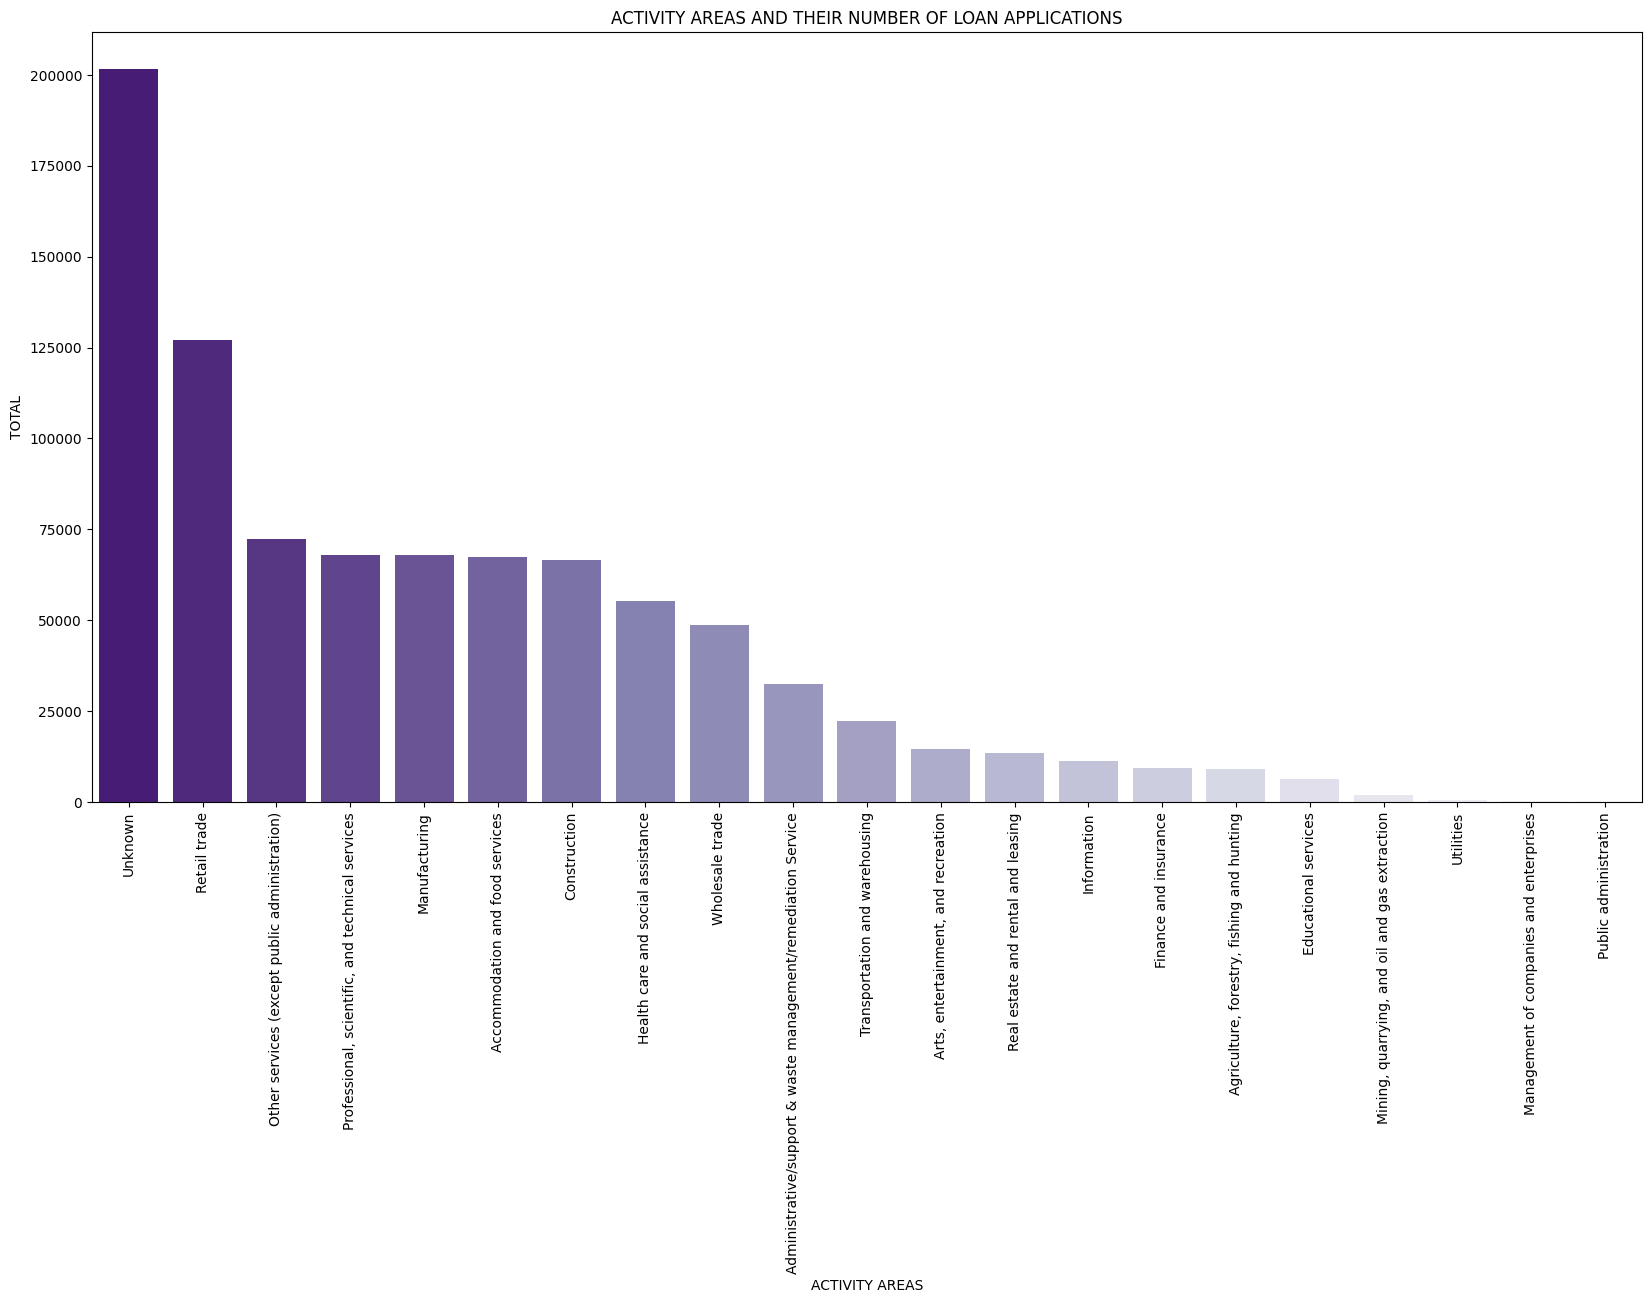

In [60]:
test = dataframe.groupby("Description").count().reset_index()
test = test.rename(columns={"Name": "Total"})
test_top = test.sort_values(by="Total", ascending=False)
test_top = test_top[["Description", "Total"]]
plt.figure(figsize=(20,10))
plt.title("ACTIVITY AREAS AND THEIR NUMBER OF LOAN APPLICATIONS")
sns.barplot(test_top, x='Description', y="Total", palette="Purples_r")
plt.xticks(rotation='vertical')
plt.xlabel("ACTIVITY AREAS")
plt.ylabel("TOTAL")
plt.show()

In [61]:
dataframe.NAICS_id.isnull().sum()

0

#### ApprovalDate = ApprovalYear, ApprovalMonth, ApprovalDay

In [62]:
dataframe.ApprovalYear.describe()

count    897167.000000
mean       2000.922194
std           5.957414
min        1974.000000
25%        1996.000000
50%        2002.000000
75%        2006.000000
max        2073.000000
Name: ApprovalYear, dtype: float64

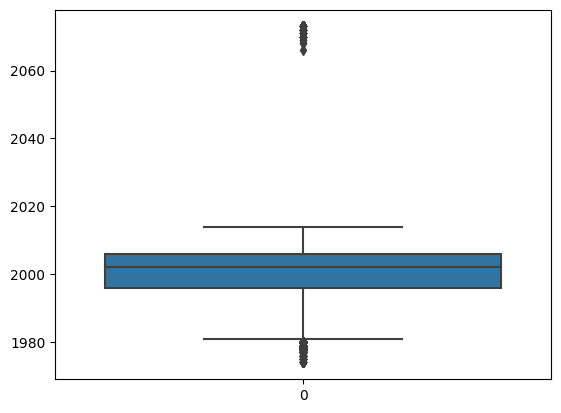

In [63]:
sns.boxplot(dataframe.ApprovalYear)
plt.show()

In [64]:
dataframe.ApprovalMonth.describe()

count    897167.000000
mean          6.483538
std           3.361659
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: ApprovalMonth, dtype: float64

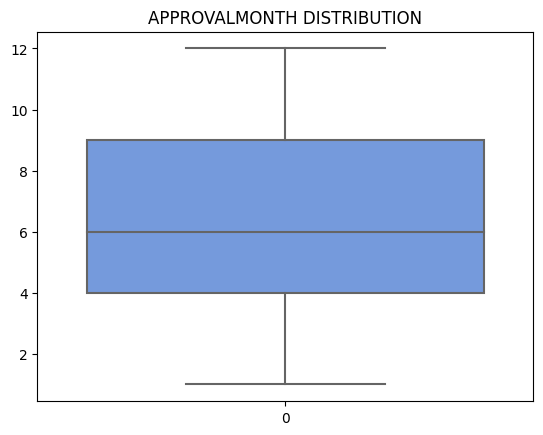

In [65]:
sns.boxplot(dataframe.ApprovalMonth, color='cornflowerblue')
plt.title("APPROVALMONTH DISTRIBUTION")
plt.show()

In [66]:
dataframe.ApprovalDay.describe()

count    897167.000000
mean         16.188073
std           8.763399
min           1.000000
25%           9.000000
50%          16.000000
75%          24.000000
max          31.000000
Name: ApprovalDay, dtype: float64

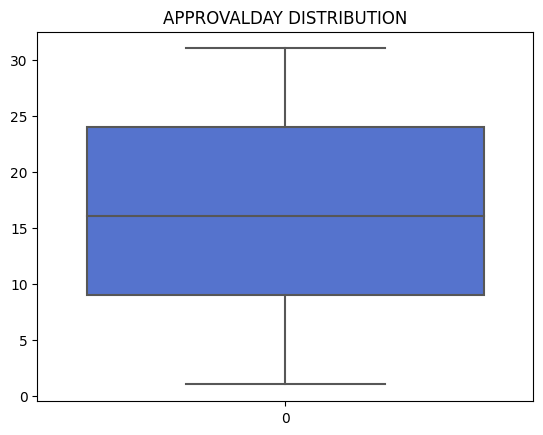

In [67]:
sns.boxplot(dataframe.ApprovalDay, color='royalblue')
plt.title("APPROVALDAY DISTRIBUTION")
plt.show()

In [68]:
# 0 NaN dans les 3 variables
dataframe.ApprovalDay.isnull().sum()

0

#### ApprovalFY

In [69]:
dataframe.ApprovalFY.isnull().sum()

0

In [70]:
dataframe.ApprovalFY.describe()

count    897167.000000
mean       2001.139677
std           5.912461
min        1966.000000
25%        1997.000000
50%        2002.000000
75%        2006.000000
max        2014.000000
Name: ApprovalFY, dtype: float64

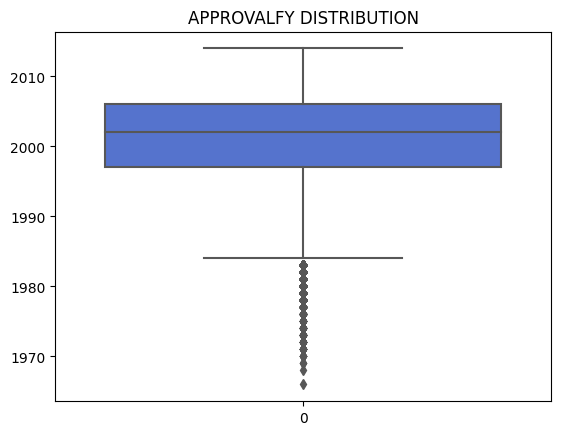

In [71]:
sns.boxplot(dataframe.ApprovalFY, color='royalblue')
plt.title("APPROVALFY DISTRIBUTION")
plt.show()

#### Term

In [72]:
dataframe.Term.isnull().sum()

0

In [73]:
dataframe.Term.describe()

count    897167.000000
mean        110.848592
std          78.900862
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

In [74]:
test = dataframe.query("Term == 0")
test.MIS_Status.value_counts()

CHGOFF    734
P I F      72
Name: MIS_Status, dtype: int64

In [75]:
calcul = 569/12
calcul

47.416666666666664

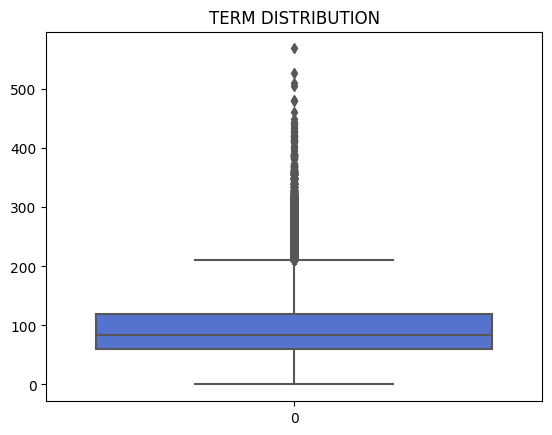

In [76]:
sns.boxplot(dataframe.Term, color='royalblue')
plt.title("TERM DISTRIBUTION")
plt.show()

#### NoEmp

In [77]:
dataframe.NoEmp.isnull().sum()

0

In [78]:
dataframe.NoEmp.describe()

count    897167.000000
mean         11.412562
std          73.793775
min           0.000000
25%           2.000000
50%           4.000000
75%          10.000000
max        9999.000000
Name: NoEmp, dtype: float64

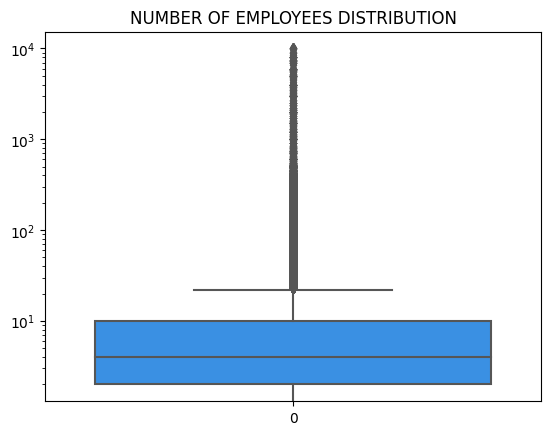

In [79]:
sns.boxplot(dataframe.NoEmp, color='dodgerblue')
plt.title("NUMBER OF EMPLOYEES DISTRIBUTION")
plt.yscale('log')
plt.show()

#### NewExist

In [80]:
dataframe.NewExist.value_counts(normalize=True, dropna=False)
# REMPLACER 2 PAR TRUE ET TOUT LE RESTE PAR FALSE (VOIR NOTEBOOK GREG)

1       0.717198
2       0.281507
0       0.001295
<NA>         0.0
Name: NewExist, dtype: Float64

In [81]:
# Séparer le dataframe en deux (deux (ou trois) variables de NewExist)
# Faire un boxplot pour chaque valeur de NewExist
# Faire un pie-plot pour montrer le %

In [82]:
# Mettre les (3) dans (0)
dataframe.NewExist.replace(3, 1, inplace=True)

In [83]:
dataframe.NewExist.isnull().sum()

0

In [84]:
# Séparer le dataframe en deux (deux (ou trois) variables de NewExist)

/home/utilisateur/.local/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/utilisateur/.local/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


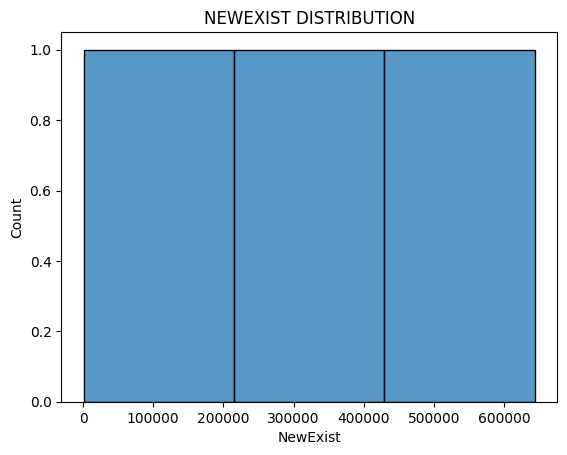

In [85]:
sns.histplot(dataframe.NewExist.value_counts())
plt.title("NEWEXIST DISTRIBUTION")
plt.show()

#### CreateJob

In [86]:
dataframe.CreateJob.describe()

count    897167.000000
mean          8.444305
std         236.950249
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        8800.000000
Name: CreateJob, dtype: float64

In [87]:
dataframe.CreateJob.isnull().sum()

0

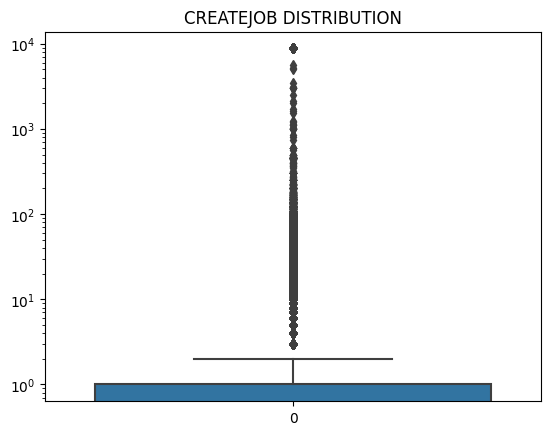

In [88]:
sns.boxplot(dataframe.CreateJob)
plt.yscale('log')
plt.title("CREATEJOB DISTRIBUTION")
plt.show()

#### RetainedJob

In [89]:
dataframe.RetainedJob.describe()

count    897167.000000
mean         10.807308
std         237.382398
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max        9500.000000
Name: RetainedJob, dtype: float64

In [90]:
dataframe.RetainedJob.isnull().sum()

0

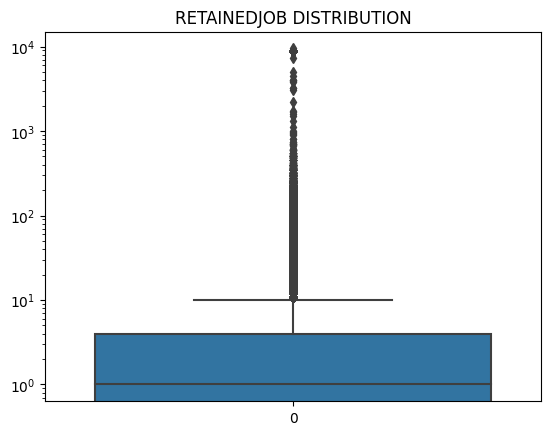

In [91]:
sns.boxplot(dataframe.RetainedJob)
plt.yscale('log')
plt.title("RETAINEDJOB DISTRIBUTION")
plt.show()

#### FranchiseCode

In [92]:
dataframe.FranchiseCode.describe()

count    897167.000000
mean       2757.528287
std       12767.025962
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       99999.000000
Name: FranchiseCode, dtype: float64

In [93]:
dataframe.FranchiseCode.isnull().sum()

0

In [94]:
dataframe.FranchiseCode.value_counts()

1        637395
0        208040
78760      3373
68020      1921
50564      1034
          ...  
28440         1
74850         1
87072         1
52320         1
9707          1
Name: FranchiseCode, Length: 2767, dtype: int64

In [95]:
# Faire un pie chart avec % franchisés et % non-franchisés
# Binariser la variable (0 et 1 = non franchisés, autre nombres = franchisé)

#### UrbanRural

In [96]:
dataframe.UrbanRural.describe()

count    897167.000000
mean          0.757274
std           0.646540
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: UrbanRural, dtype: float64

In [97]:
dataframe.UrbanRural.isnull().sum()

0

In [98]:
dataframe.UrbanRural.value_counts()

1    469281
0    322826
2    105060
Name: UrbanRural, dtype: int64

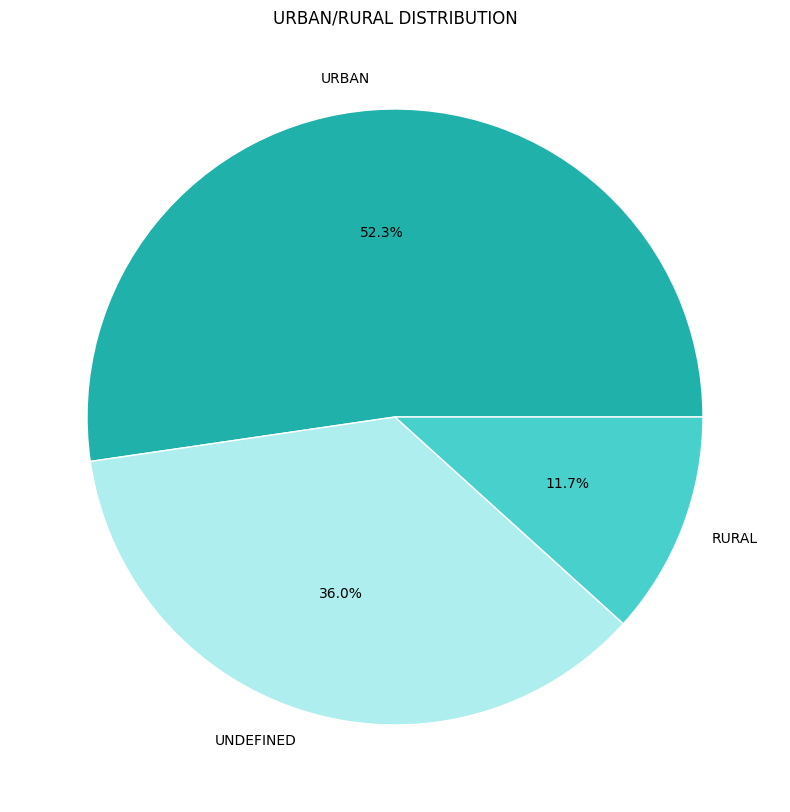

In [99]:
plt.figure(figsize=(10,10))
labels = ["URBAN", "UNDEFINED", "RURAL"]
colors = ["lightseagreen", "paleturquoise", "mediumturquoise"]
plt.title("URBAN/RURAL DISTRIBUTION")
plt.pie(dataframe.UrbanRural.value_counts(), labels=labels, colors=colors, autopct='%1.1f%%', wedgeprops={'edgecolor':'white'})
plt.show()

In [100]:
# MODIFICATION DES VALEURS DE LA VARIABLE UrbanRural
mapping = {0: "M", 1: "U", 2: "R"}
dataframe["UrbanRural"] = dataframe["UrbanRural"].map(mapping)
dataframe.UrbanRural.value_counts()

U    469281
M    322826
R    105060
Name: UrbanRural, dtype: int64

#### RevLineCR & LowDoc

In [101]:
dataframe.RevLineCr.describe()

count     892647
unique        18
top            N
freq      419252
Name: RevLineCr, dtype: object

In [102]:
dataframe.RevLineCr.isnull().sum()

4520

In [103]:
dataframe.RevLineCr.value_counts()

N    419252
0    257431
Y    200660
T     15239
1        23
R        14
`        11
2         6
C         2
.         1
A         1
4         1
3         1
5         1
-         1
7         1
,         1
Q         1
Name: RevLineCr, dtype: int64

In [104]:
def change(value):
    if value != "N" and value != "Y":
        return "UNKNOWN"
    return value

dataframe["RevLineCr"] = dataframe["RevLineCr"].apply(change)
dataframe.RevLineCr.value_counts()

N          419252
UNKNOWN    277255
Y          200660
Name: RevLineCr, dtype: int64

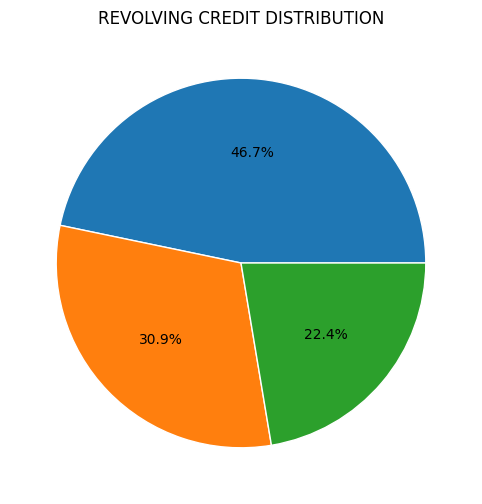

In [105]:
labels = ["NOT REVOLVING CREDIT", "UNKNOWN", "REVOLVING CREDIT"]
plt.figure(figsize=(10,6))
plt.pie(dataframe.RevLineCr.value_counts(), autopct='%1.1f%%',wedgeprops={'edgecolor':'white'})
plt.title("REVOLVING CREDIT DISTRIBUTION")
plt.show()

In [106]:
# Mettre les valeurs bizarres de LowDoc dans Y (YES)
# Prendre la fonction sur notebook Greg

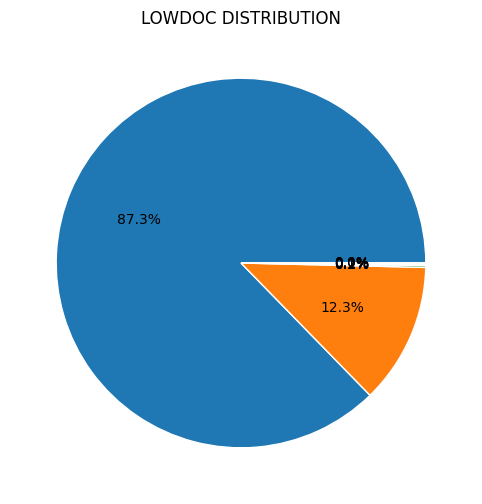

In [107]:
# PIE CHART A FAIRE POUR LOWDOC

labels = ["YES", "NO"]
plt.figure(figsize=(10,6))
plt.pie(dataframe.LowDoc.value_counts(), autopct='%1.1f%%',wedgeprops={'edgecolor':'white'})
plt.title("LOWDOC DISTRIBUTION")
plt.show()

#### GrAppv & SBA_Appv (voire notebook Greg)

In [108]:
dataframe.GrAppv 

0          60000.0
1          39500.0
2          30000.0
3          20000.0
4          28300.0
            ...   
899159    800000.0
899160     55000.0
899161    967500.0
899162    210000.0
899163    400000.0
Name: GrAppv, Length: 897167, dtype: float64

#### Recession

In [109]:
dataframe.Recession.value_counts()

False    708114
True     189053
Name: Recession, dtype: int64

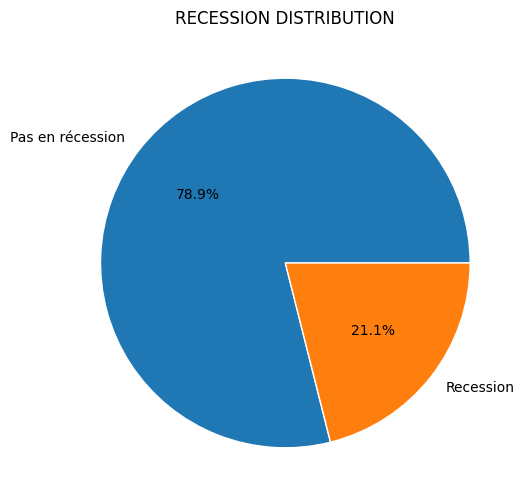

In [110]:
labels = ["Pas en récession", "Recession"]
plt.figure(figsize=(10,6))

plt.pie(dataframe.Recession.value_counts(), labels=labels, autopct='%1.1f%%',wedgeprops={'edgecolor':'white'})
plt.title("RECESSION DISTRIBUTION")
plt.show()

In [111]:
dataframe.Recession.describe()

count     897167
unique         2
top        False
freq      708114
Name: Recession, dtype: object

#### TARGET

In [112]:
dataframe.MIS_Status.describe()

count     897167
unique         2
top        P I F
freq      739609
Name: MIS_Status, dtype: object

In [113]:
dataframe.MIS_Status.isnull().sum()

0

In [114]:
dataframe.MIS_Status.value_counts()

P I F     739609
CHGOFF    157558
Name: MIS_Status, dtype: int64

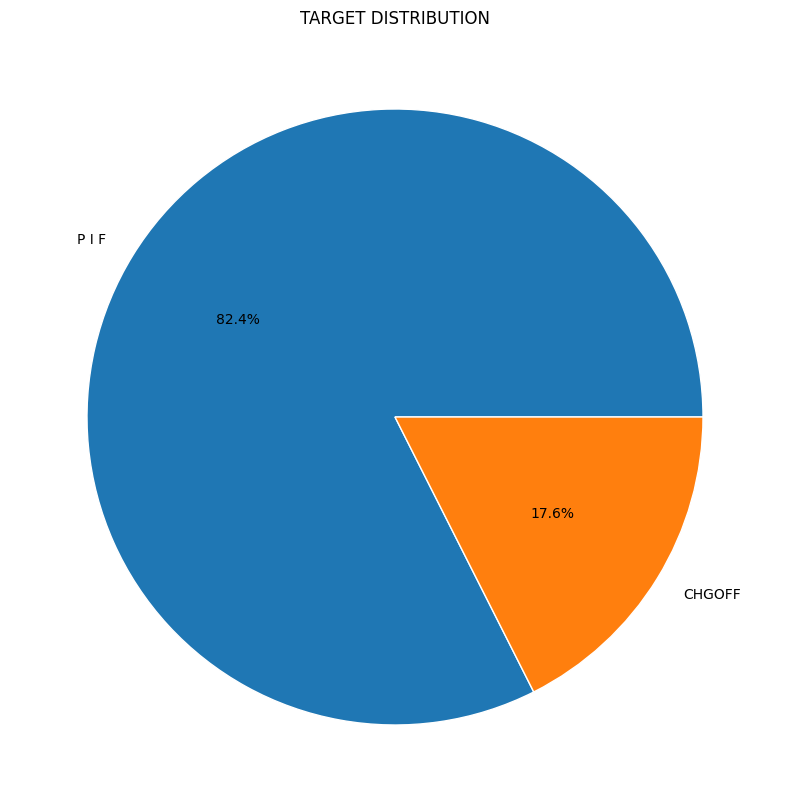

In [115]:
plt.figure(figsize=(10,10))
labels = ["P I F", "CHGOFF"]
plt.title("TARGET DISTRIBUTION")
plt.pie(dataframe.MIS_Status.value_counts(), labels=labels, autopct='%1.1f%%', wedgeprops={'edgecolor':'white'})
plt.show()

In [116]:
dataframe.columns 

Index(['Name', 'State', 'Bank', 'BankState', 'NAICS', 'ApprovalFY', 'Term',
       'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode',
       'UrbanRural', 'RevLineCr', 'LowDoc', 'MIS_Status', 'GrAppv', 'SBA_Appv',
       'ApprovalYear', 'ApprovalMonth', 'ApprovalDay', 'Recession', 'NAICS_id',
       'Description', 'SameState'],
      dtype='object')

# MACHINE LEARNING

### PYCARET

In [117]:
#pip install pycaret

In [118]:
from pycaret.classification import *
df_test = data.copy()
df_test = df_test.dropna()
session = setup(data=dataframe, target='MIS_Status', normalize=True, train_size=0.8, fold=3, data_split_stratify=True, session_id=0)

,Description,Value
0,Session id,0
1,Target,MIS_Status
2,Target type,Binary
3,Target mapping,"CHGOFF: 0, P I F: 1"
4,Original data shape,"(897167, 25)"
5,Transformed data shape,"(897167, 56)"
6,Transformed train set shape,"(717733, 56)"
7,Transformed test set shape,"(179434, 56)"
8,Numeric features,14
9,Categorical features,8


In [119]:
algo = models()
print(algo)

                                     Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
xgboost         Extreme Gradient Boosting   
lightgbm  Light Gradient Boosting Machine   
catboost              CatBoost Classifier   
dummy                    Dummy Classifier   

                                                  Refe

In [120]:
# from pycaret.classification import compare_models
# top_models = compare_models(sort="Recall")
# print(top_models)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:25:33
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8275,0.8412,0.8275,0.7881,0.7657,0.0827,0.1489,13.3600


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

KeyboardInterrupt: 